# Word2Vec with LSTM

In [53]:
import numpy as np
import pandas as pd
import os
import nltk
import sklearn
from gensim.models import Word2Vec
import re
import multiprocessing
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from collections import Counter
from nltk.stem.lancaster import LancasterStemmer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support,confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import tensorboard
tensorboard.__version__
from datetime import datetime
from packaging import version
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from beautifultable import BeautifulTable

In [3]:
#function to extract data from the file

def read_file(df_new):
    print("Started extracting data from file",df_new.shape)
    dfnew=pd.DataFrame()
    dfnew.insert(0,'Post',None)
    dfnew.insert(1,'class',None)
    for val in df_new.values:
        appList=[]
        sp=np.array_str(val).split(",")
        if len(sp)==2:
            appList.append(sp[0])
            appList.append(sp[1])
            dfnew.loc[len(dfnew)]=appList
    for i in range(0,dfnew.shape[0]):
        dfnew.values[i][1]=int(dfnew.values[i][1].strip("\'|]|\""))
    print(dfnew['class'].value_counts())
    print("Finished extracting data from file",dfnew.shape)
    return dfnew

In [4]:
#performing data cleaning on the formspring.me dataset

def post_tokenizing_dataset1(df):
    print("Started cleaning data in dataframe", df.shape)
    #print(df.head(5))
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    lancaster_stemmer=LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    token_list=[]
    phrase_list=[]
    token_df=pd.DataFrame()
    token_df.insert(0,'Post',None)
    token_df.insert(1,'class',None)
    for val in df.values:
        append_list=[]
        filter_val=re.sub(r'Q:','',val[0])
        filter_val=re.sub(r'&#039;[a-z]{1}','',filter_val)
        filter_val=re.sub('<[a-z]+>',' ',filter_val).lower()
        filter_val=re.sub(r'[^a-zA-Z\s]', '', filter_val, re.I|re.A)
        filter_val=[token for token in wpt.tokenize(filter_val)]
        filter_val=[word for word in filter_val if word.isalpha()]
        lemma_tokens=[wordnet_lemmatizer.lemmatize(token) for token in filter_val if token not in stop_words and len(token)>=3]
        lancaster_tokens = [lancaster_stemmer.stem(word) for word in lemma_tokens]
        if(lancaster_tokens):
            append_list.append(' '.join(lancaster_tokens))
            append_list.append(val[1])
            token_df.loc[len(token_df)]=append_list
    print("Finished cleaning data in dataframe",token_df.shape)
    #print(token_df.head(5))
    return token_df

In [5]:
#performing data cleaning on the twitter dataset

def post_tokenizing_dataset3(df):
    print("Started cleaning data in dataframe", df.shape)
    #print(df.head(5))
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    lancaster_stemmer=LancasterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    token_df=pd.DataFrame()
    token_df.insert(0,'Post',None)
    token_df.insert(1,'class',None)
    
    for val in df.values:
        filter_val=[]
        value=re.sub(r'@\w*','',val[0])
        value=re.sub(r'&.*;','',value)
        value=re.sub(r'http[s?]?:\/\/.*[\r\n]*','',value)
        tokens=[token for token in wpt.tokenize(value)]
        tokens=[word for word in tokens if word.isalpha()]
        lemma_tokens=[wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token)>=3]
        lancaster_tokens = [lancaster_stemmer.stem(word) for word in lemma_tokens]
        if len(lancaster_tokens)!=0:
            filter_val.append(' '.join(lancaster_tokens).lower())
            filter_val.append(val[1])
            token_df.loc[len(token_df)]=filter_val
    
    print("Finished cleaning data in dataframe",token_df.shape)
    #print(token_df.head(5))
    return token_df

In [6]:
#removal of words which occur once

def remove_less_occurent_words(token_df,counter):
    print("Started removing less occurent words",token_df.shape)
    token_df_2=pd.DataFrame()
    token_df_2.insert(0,'Post',None)
    token_df_2.insert(1,'class',None)
    less_list=[]
    for key,val in counter.items():
        if(val==1):
            less_list.append(key)
    for val in token_df.values:
        list_2=[]
        split_list=[]
        split_list=val[0].split(' ')
        for word in split_list:
            if word in less_list:
                split_list.remove(word)
        list_2.append(' '.join(split_list))
        list_2.append(val[1])
        token_df_2.loc[len(token_df_2)]=list_2
    print("Finished removing less occurent words",token_df_2.shape)
    return token_df_2

In [7]:
#counting the number of unique words in the corpora

def counter_word(text):
    print("Started counting words")
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    print("Finished counting words")
    return count

In [8]:
#getting the data from csv files

df_data_1=read_file(pd.read_csv("../../post.csv",sep="\t"))
df_data_2=read_file(pd.read_csv("../../new_data.csv",sep=","))
df_data_3=pd.read_csv("../../dataset_4.csv",sep=",")

Started extracting data from file (12642, 1)
0    10794
1     1848
Name: class, dtype: int64
Finished extracting data from file (12642, 2)
Started extracting data from file (8856, 1)
0    6312
1    2505
Name: class, dtype: int64
Finished extracting data from file (8817, 2)


In [9]:
#calling the function post_tokenizing_dataset1() and post_tokenizing_dataset3() for cleaning

df_data_1=post_tokenizing_dataset1(df_data_1)
tk=df_data_3[df_data_3['class']==1].iloc[0:8000,]
post_tk=post_tokenizing_dataset3(tk)
post_tk=post_tk.append(df_data_1[df_data_1['class']==0].iloc[0:7500,], ignore_index=True)
print(post_tk['class'].value_counts())

post_tk=sklearn.utils.shuffle(post_tk)
counter_tk = counter_word(post_tk['Post'])
print(len(counter_tk))
token_tk=remove_less_occurent_words(post_tk,counter_tk)
print(tk.shape)

Started cleaning data in dataframe (12642, 2)
Finished cleaning data in dataframe (12589, 2)
Started cleaning data in dataframe (8000, 2)
Finished cleaning data in dataframe (7584, 2)
1    7584
0    7500
Name: class, dtype: int64
Started counting words
Finished counting words
12589
Started removing less occurent words (15084, 2)
Finished removing less occurent words (15084, 2)
(8000, 2)


In [10]:
token_list=[]
total_words_max=0
for val in token_tk.values:
    token_list.append(val[0].split())
    if total_words_max<len(val[0].split()):
        total_words_max=len(val[0].split())
print(total_words_max)

109


In [11]:
#Building a Word2Vec model

em_dim=300
cores = multiprocessing.cpu_count()
embeddings=Word2Vec(token_list,min_count=5,
                 window=5,
                 size=em_dim,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=cores)
words=list(embeddings.wv.vocab)
print("Total vocabulary size:",len(words))
#docs_vectors=post_vector_calculation(token_list,embeddings)


Total vocabulary size: 2726


In [12]:
#Pushing the vector values of each word into a file for creating an embedding matrix below.

filename="word2vec_embeddings.txt"
embeddings.wv.save_word2vec_format(filename, binary=False)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(token_tk['Post'],token_tk['class'],test_size = 0.2,stratify=token_tk['class'],
                                                   random_state = 42)

In [14]:
print(X_train.shape, X_test.shape)

(12067,) (3017,)


In [15]:
print(y_train.shape,y_test.shape)

(12067,) (3017,)


In [16]:
#converting the post to sequences and padding to equal length

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq=tokenizer.texts_to_sequences(X_train)
X_test_seq=tokenizer.texts_to_sequences(X_test)

vocab_size=len(tokenizer.word_index)+1

X_train_pad=pad_sequences(X_train_seq,maxlen=total_words_max,padding="post", truncating="post")
X_test_pad=pad_sequences(X_test_seq,maxlen=total_words_max,padding="post", truncating="post")

In [17]:
embeddings_index={}
f=open(os.path.join('','word2vec_embeddings.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()
embedding_matrix=np.zeros((vocab_size,em_dim))
for word,i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(vocab_size)

5842


In [18]:
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [61]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Masking, Activation, Input,Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
embedding_layer = Embedding(input_dim=vocab_size,output_dim=em_dim,
                            weights=[embedding_matrix], trainable=True,
                            mask_zero=True)

lstm_layer= LSTM(units=em_dim,dropout=rate_drop_lstm,recurrent_dropout=rate_drop_lstm)

model=Sequential()
model.add(embedding_layer)
model.add(lstm_layer)
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives()])


In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         1752600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 2,474,101
Trainable params: 2,474,101
Non-trainable params: 0
_________________________________________________________________


In [58]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [23]:
from tensorflow import keras
logdir="C:/temp/tensorflow_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
final_model = model.fit(
    X_train_pad, y_train,epochs=5,validation_data=(X_test_pad, y_test)
)

Epoch 1/5
378/378 [==============================] - 573s 2s/step - loss: 0.2256 - accuracy: 0.9224 - precision: 0.9307 - recall: 0.9138 - auc: 0.9759 - true_negatives: 5587.0000 - true_positives: 5544.0000 - false_negatives: 523.0000 - false_positives: 413.0000 - val_loss: 0.1087 - val_accuracy: 0.9659 - val_precision: 0.9676 - val_recall: 0.9644 - val_auc: 0.9920 - val_true_negatives: 1451.0000 - val_true_positives: 1463.0000 - val_false_negatives: 54.0000 - val_false_positives: 49.0000
Epoch 2/5
378/378 [==============================] - 567s 2s/step - loss: 0.0653 - accuracy: 0.9770 - precision: 0.9862 - recall: 0.9677 - auc: 0.9969 - true_negatives: 5918.0000 - true_positives: 5871.0000 - false_negatives: 196.0000 - false_positives: 82.0000 - val_loss: 0.1013 - val_accuracy: 0.9652 - val_precision: 0.9663 - val_recall: 0.9644 - val_auc: 0.9924 - val_true_negatives: 1449.0000 - val_true_positives: 1463.0000 - val_false_negatives: 54.0000 - val_false_positives: 51.0000
Epoch 3/5
378

AttributeError: 'History' object has no attribute 'save'

In [23]:
model.save("Word2Vec_LSTM.model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Word2Vec_LSTM.model\assets


In [25]:
pred_val=model.predict_classes(X_test_pad)
tn, fp, fn, tp = confusion_matrix(y_test,pred_val).ravel()
print("Confusion matrix:  tn={tn},  fp={fp},  fn={fn},  tp={tp}".format(tn=tn,fp=fp,fn=fn,tp=tp))

Confusion matrix:  tn=1422,  fp=78,  fn=51,  tp=1466


In [27]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred_val)
auc_keras = auc(fpr_keras, tpr_keras)

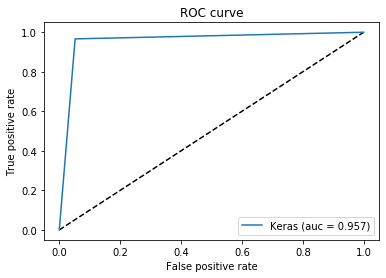

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (auc = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
LSTM_accuracy=final_model.history['val_accuracy'][4]
LSTM_precision=final_model.history['val_precision'][4]
LSTM_recall=final_model.history['val_recall'][4]
LSTM_f1_score= 2 * ((LSTM_precision*LSTM_recall)/(LSTM_precision+LSTM_recall))

In [54]:
h0=["Algorithm"]
h1=["LSTM",LSTM_accuracy,LSTM_f1_score,LSTM_precision,LSTM_recall]

h0.append("Accuracy")
h0.append("F1 Measure")
h0.append("Precision")
h0.append("Recall")

table = BeautifulTable()
table.column_headers = h0
table.append_row(h1)
print(table)

+-----------+----------+------------+-----------+--------+
| Algorithm | Accuracy | F1 Measure | Precision | Recall |
+-----------+----------+------------+-----------+--------+
|   LSTM    |  0.957   |   0.958    |   0.949   | 0.966  |
+-----------+----------+------------+-----------+--------+


C:\Users\aml_alx\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
C:\Users\aml_alx\Anaconda3\lib\site-packages\beautifultable\utils.py:113: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


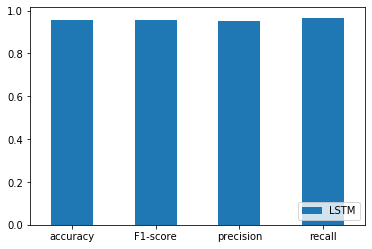

In [32]:
LSTM_metrics=np.array([LSTM_accuracy,LSTM_f1_score,LSTM_precision,LSTM_recall])
index = ['accuracy', 'F1-score', 'precision', 'recall']
df_metrics = pd.DataFrame({'LSTM': LSTM_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

## Testing

In [46]:
test_data=pd.DataFrame()
t1=df_data_2[df_data_2['class']==0].iloc[0:1000,]
t1=post_tokenizing_dataset1(t1)
t2=df_data_3[df_data_3['class']==1].iloc[8001:9000,]
t2=post_tokenizing_dataset3(t2)
test_data=test_data.append(t1 , ignore_index = True)
test_data=test_data.append(t2 , ignore_index = True)
test_data=sklearn.utils.shuffle(test_data)
print(test_data['class'].value_counts())

Started cleaning data in dataframe (1000, 2)
Finished cleaning data in dataframe (998, 2)
Started cleaning data in dataframe (999, 2)
Finished cleaning data in dataframe (998, 2)
1    998
0    998
Name: class, dtype: int64


In [47]:
counter_test= counter_word(test_data['Post'])
print(len(counter_test))
test_data=remove_less_occurent_words(test_data,counter_test)
token_list_test=[]
maxi_test=0
for val in test_data.values:
    token_list_test.append(val[0].split())
    if maxi_test<len(val[0].split()):
        maxi_test=len(val[0].split())
print(maxi_test)

Started counting words
Finished counting words
3402
Started removing less occurent words (1996, 2)
Finished removing less occurent words (1996, 2)
19


In [48]:
sequences_test=tokenizer.texts_to_sequences(token_list_test)
review_pad_test=pad_sequences(sequences_test,maxlen=maxi_test,padding="post", truncating="post")

In [49]:
def model_evaluation(X_test, y_test, model):
    _predicted_values = model.predict_classes(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    tn, fp, fn, tp = confusion_matrix(y_test, _predicted_values).ravel()
    print("Confusion matrix:  tn={tn},  fp={fp},  fn={fn},  tp={tp}".format(tn=tn,fp=fp,fn=fn,tp=tp))
    return _accuracy, _precision[0], _recall[0], _f1_score[0]

In [50]:
X=review_pad_test
y=test_data['class']
y=y.astype('int')
accuracy, precision, recall, f1=model_evaluation(X,y,model)
print("accuracy:{a},   precision:{p},   recall:{r},   f1:{f}".format(a=accuracy,p=precision,r=recall,f=f1))

Confusion matrix:  tn=664,  fp=334,  fn=44,  tp=954
accuracy:0.8106212424849699,   precision:0.7406832298136646,   recall:0.9559118236472945,   f1:0.8346456692913387


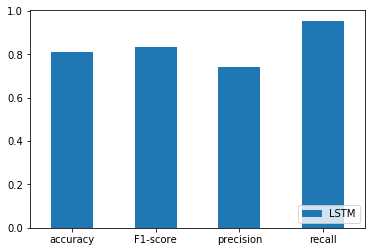

In [51]:
LSTM_metrics_test=np.array([accuracy,f1,precision,recall])
index = ['accuracy', 'F1-score', 'precision', 'recall']
df_metrics = pd.DataFrame({'LSTM': LSTM_metrics_test}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()